In [77]:
! pip install chembl_webresource_client

import pandas as pd
import numpy as np
from chembl_webresource_client.new_client import new_client

Endometriosis is associated with progesterone resistance: https://pmc.ncbi.nlm.nih.gov/articles/PMC9687824/. 
Therefore, in drug discoveries to relieve endometriosis, we're looking for substances that can activate Progesterone receptors and improve binding

In [95]:
target = new_client.target
target_query = target.search('progesterone') 
targets = pd.DataFrame.from_dict(target_query)

Using id[0] to return the protein associated with homo sapien. 

In [96]:
selected = targets.target_chembl_id[0]
activity = new_client.activity
res = activity.filter(target_chembl_id = selected).filter(standard_type = "IC50") #IC50 means that the potency is measured by amount needed to halt biological processes by 50%: https://pubmed.ncbi.nlm.nih.gov/27365221/

df = pd.DataFrame.from_dict(res)[lambda d: d.standard_value.notna()] #need standard value to determine potency
df.head(3)

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,184563,[],CHEMBL749963,In vitro antagonist potency in transactivation...,F,None,None,BAO_0000190,...,Homo sapiens,Progesterone receptor,9606,None,None,IC50,nM,UO_0000065,None,0.028
1,None,None,184565,[],CHEMBL750122,In vitro antagonist potency in transactivation...,F,None,None,BAO_0000190,...,Homo sapiens,Progesterone receptor,9606,None,None,IC50,nM,UO_0000065,None,0.025
2,None,None,214573,[],CHEMBL749958,In vitro antagonist potency in transactivation...,F,None,None,BAO_0000190,...,Homo sapiens,Progesterone receptor,9606,None,None,IC50,nM,UO_0000065,None,0.0036


In [97]:
#adding activity label for ML

act_class = []
for i in df.standard_value:
    if float(i) >= 10000:
        act_class.append("inactive")
    elif float(i) <= 1000:
        act_class.append("active")
    else:
        act_class.append("intermediate")


#combining into df
finaldf = df[['molecule_chembl_id', 'canonical_smiles', 'standard_value']] 
#canonical smile is another way to depict molecular structure in text: https://luis-vollmers.medium.com/tutorial-to-smiles-and-canonical-smiles-explained-with-examples-fbc8a46ca29f
finaldf = pd.concat([finaldf, pd.Series(act_class, name = 'bioactivity_class')], axis = 1)


Lipiski descriptors: the "druglikeness" of a compound (absorption, distribution, metabolism, excretion), or the pharmacokinetic profile.

In [98]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors


MW = molecular weight; LogP = Octanol-water partition coefficient (measure of hydrophobism); hydrogen donors and acceptors

In [99]:
finaldf= finaldf.dropna(subset = ['canonical_smiles'])
lip_df = lipinski(finaldf.canonical_smiles)
df_combine = pd.concat([finaldf, lip_df], axis = 1)
df_combine['standard_value'] = pd.to_numeric(df_combine['standard_value'])
df_combine

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL1276308,CC#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CCC4=C3[...,0.0280,active,429.604,5.40650,1.0,3.0
1,CHEMBL1276308,CC#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CCC4=C3[...,0.0250,active,429.604,5.40650,1.0,3.0
2,CHEMBL146032,CC(=O)c1ccc([C@H]2C[C@@]3(C)[C@@H](CC[C@@]3(O)...,0.0036,active,508.527,6.71740,1.0,3.0
3,CHEMBL146032,CC(=O)c1ccc([C@H]2C[C@@]3(C)[C@@H](CC[C@@]3(O)...,0.0025,active,508.527,6.71740,1.0,3.0
4,CHEMBL286130,C=C1CC(C)(C)Nc2ccc3c(c21)C(c1ccc(Cl)cc1)Oc1ccc...,1755.0000,intermediate,387.910,7.09620,1.0,2.0
...,...,...,...,...,...,...,...,...
1525,NaN,NaN,NaN,NaN,357.312,3.30990,1.0,4.0
1527,NaN,NaN,NaN,NaN,353.349,3.40280,1.0,4.0
1533,NaN,NaN,NaN,NaN,424.488,4.85348,2.0,2.0
1534,NaN,NaN,NaN,NaN,452.285,4.50880,3.0,3.0


In [100]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', axis =1)
        
    return x

df_norm = norm_value(df_combine)


In [101]:
def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', axis =1)
        
    return x

df_final = pIC50(df_norm)
df_final

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL1276308,CC#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CCC4=C3[...,active,429.604,5.40650,1.0,3.0,10.552842
1,CHEMBL1276308,CC#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CCC4=C3[...,active,429.604,5.40650,1.0,3.0,10.602060
2,CHEMBL146032,CC(=O)c1ccc([C@H]2C[C@@]3(C)[C@@H](CC[C@@]3(O)...,active,508.527,6.71740,1.0,3.0,11.443697
3,CHEMBL146032,CC(=O)c1ccc([C@H]2C[C@@]3(C)[C@@H](CC[C@@]3(O)...,active,508.527,6.71740,1.0,3.0,11.602060
4,CHEMBL286130,C=C1CC(C)(C)Nc2ccc3c(c21)C(c1ccc(Cl)cc1)Oc1ccc...,intermediate,387.910,7.09620,1.0,2.0,5.755723
...,...,...,...,...,...,...,...,...
1525,NaN,NaN,NaN,357.312,3.30990,1.0,4.0,NaN
1527,NaN,NaN,NaN,353.349,3.40280,1.0,4.0,NaN
1533,NaN,NaN,NaN,424.488,4.85348,2.0,2.0,NaN
1534,NaN,NaN,NaN,452.285,4.50880,3.0,3.0,NaN


figure 1: bioactivity frequencies

Text(0, 0.5, 'Frequency')

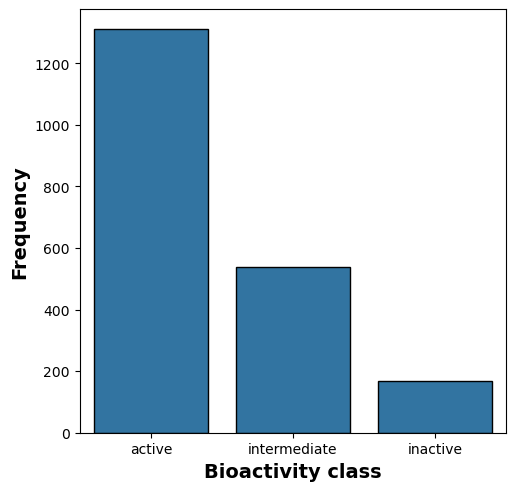

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5.5, 5.5))

sns.countplot(x= 'bioactivity_class', data= df_final, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')


Figure 2: molecular weight v octanol-water partition coefficient

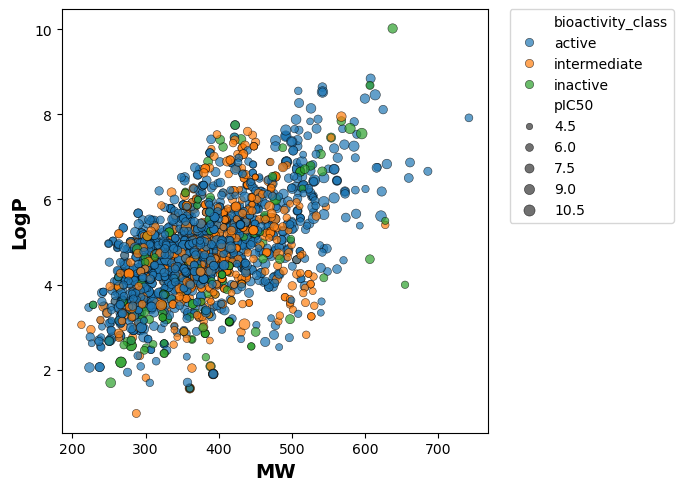

In [103]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_final, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

Figure 3: pIC50 values, molecular weight frequencies, octanol-water coefficients, and H donors/acceptors over class types


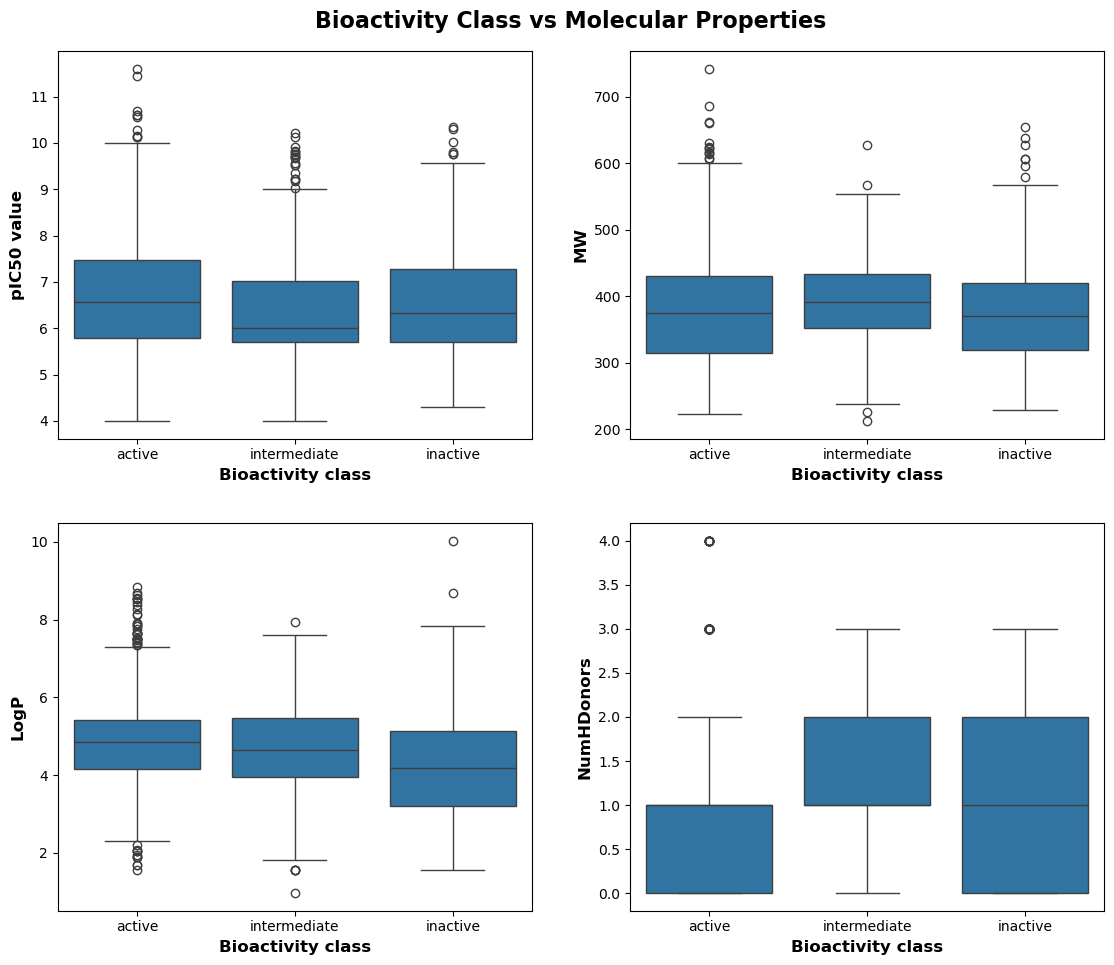

In [109]:

# Set up a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.tight_layout(pad=4.0)  # Adjust spacing between subplots

# First boxplot: pIC50
sns.boxplot(ax=axes[0, 0], x='bioactivity_class', y='pIC50', data=df_final)
axes[0, 0].set_xlabel('Bioactivity class', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('pIC50 value', fontsize=12, fontweight='bold')

# Second boxplot: MW
sns.boxplot(ax=axes[0, 1], x='bioactivity_class', y='MW', data=df_final)
axes[0, 1].set_xlabel('Bioactivity class', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('MW', fontsize=12, fontweight='bold')

# Third boxplot: LogP
sns.boxplot(ax=axes[1, 0], x='bioactivity_class', y='LogP', data=df_final)
axes[1, 0].set_xlabel('Bioactivity class', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('LogP', fontsize=12, fontweight='bold')

# Fourth boxplot: NumHDonors
sns.boxplot(ax=axes[1, 1], x='bioactivity_class', y='NumHDonors', data=df_final)
axes[1, 1].set_xlabel('Bioactivity class', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('NumHDonors', fontsize=12, fontweight='bold')

# Optional: Add a main title
fig.suptitle('Bioactivity Class vs Molecular Properties', fontsize=16, fontweight='bold')

plt.show()


Mann-Whitney U test for statistical significance of two groups (active and inactive)

In [115]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'bioactivity_class']
  df = df_final[selection]
  active = df[df.bioactivity_class == 'active']
  active = active[descriptor]

  selection = [descriptor, 'bioactivity_class']
  df = df_final[selection]
  inactive = df[df.bioactivity_class == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'

  return results

In [114]:
pd.concat([mannwhitney('pIC50'),mannwhitney('MW'), mannwhitney('LogP'), mannwhitney('NumHDonors'),mannwhitney('NumHAcceptors')  ], axis=0)

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,116455.0,1.731365e-01,0.05,Same distribution (fail to reject H0)
0,MW,110936.0,7.651690e-01,0.05,Same distribution (fail to reject H0)
0,LogP,140225.0,2.830282e-09,0.05,Different distribution (reject H0)
0,NumHDonors,106648.0,5.617597e-01,0.05,Same distribution (fail to reject H0)
0,NumHAcceptors,92786.5,9.225543e-04,0.05,Different distribution (reject H0)


Seeing as logP and H-bond acceptors deviated from the null hypothesis, those are some correlations that I will test in bio_ml.ipynb

In [116]:
df_final.to_csv('final_export.csv', index = False)